# Zaawansowane ML (tworzenie pipeline'ów)

In [29]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

In [30]:
dataset = pd.read_csv('titanic.csv')
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [31]:
X = dataset.drop(['Survived'], axis=1).copy()
y = dataset['Survived'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                    random_state=42, stratify=y)

# Czym jest Pipeline?

In [32]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']

In [33]:
# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[('fill_missings', 
                                    SimpleImputer(strategy='mean'))])

In [34]:
print('Surowy zbiór danych - zbiór treningowy:')
print(X_train[num_features].isnull().mean())
X_train_trasnformed = num_preparation.fit_transform(X_train[num_features])
X_train_trasnformed = pd.DataFrame(X_train_trasnformed, columns=num_features)
print('\nWyjście Pipeline - zbiór treningowy')
print(X_train_trasnformed[num_features].isnull().mean())

Surowy zbiór danych - zbiór treningowy:
Age      0.196108
SibSp    0.000000
Parch    0.000000
Fare     0.000000
dtype: float64

Wyjście Pipeline - zbiór treningowy
Age      0.0
SibSp    0.0
Parch    0.0
Fare     0.0
dtype: float64


In [35]:
print('Surowy zbiór danych - zbiór testowy:')
print(X_test[num_features].isnull().mean())
X_test_trasnformed = num_preparation.transform(X_test[num_features])
X_test_trasnformed = pd.DataFrame(X_test_trasnformed, columns=num_features)
print('\nWyjście Pipeline - zbiór testowy')
print(X_test_trasnformed[num_features].isnull().mean())


Surowy zbiór danych - zbiór testowy:
Age      0.206278
SibSp    0.000000
Parch    0.000000
Fare     0.000000
dtype: float64

Wyjście Pipeline - zbiór testowy
Age      0.0
SibSp    0.0
Parch    0.0
Fare     0.0
dtype: float64


# Column Transformer

In [36]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[('fill_missings', 
                                    SimpleImputer(strategy='mean'))])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)])

In [37]:
data_preparation.fit_transform(X_train)

array([[35.    ,  1.    ,  0.    , 90.    ],
       [19.    ,  0.    ,  0.    , 10.5   ],
       [34.    ,  0.    ,  0.    , 13.    ],
       ...,
       [48.    ,  1.    ,  3.    , 34.375 ],
       [47.    ,  0.    ,  0.    , 38.5   ],
       [27.    ,  0.    ,  0.    ,  8.6625]])

# Custom Transformer

In [38]:
class Filter_Name(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y = None ):
        return self

    def transform(self, X, y = None ):
        X_transformed = X.copy()
        column = self.column
        X_transformed[column] = X_transformed[column].str.split(', ', 
                                        expand=True)[1].str.split('.', expand=True)[0]
        X_transformed.loc[~X_transformed[column].isin(['Mr', 'Miss', 'Mrs']), 
                                                        column] = 'Other'
        return X_transformed

In [39]:
transformer_filter_name = Filter_Name(column='Name')
display(X_train[['Name']])
display(transformer_filter_name.fit_transform(X_train[['Name']]))

,Name
486,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)"
238,"Pengelly, Mr. Frederick William"
722,"Gillespie, Mr. William Henry"
184,"Kink-Heilmann, Miss. Luise Gretchen"
56,"Rugg, Miss. Emily"
...,...
547,"Padro y Manent, Mr. Julian"
469,"Baclini, Miss. Helene Barbara"
736,"Ford, Mrs. Edward (Margaret Ann Watson)"
462,"Gee, Mr. Arthur H"


,Name
486,Mrs
238,Mr
722,Mr
184,Miss
56,Miss
...,...
547,Mr
469,Miss
736,Mrs
462,Mr


In [40]:
cat_features = ['Name', 'Sex', 'Embarked']

# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name'))])

In [41]:
print('Przed')
display(X_train[cat_features])
print('Po')
display(cat_preparation.fit_transform(X_train[cat_features]))

Przed


,Name,Sex,Embarked
486,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,S
238,"Pengelly, Mr. Frederick William",male,S
722,"Gillespie, Mr. William Henry",male,S
184,"Kink-Heilmann, Miss. Luise Gretchen",female,S
56,"Rugg, Miss. Emily",female,S
...,...,...,...
547,"Padro y Manent, Mr. Julian",male,C
469,"Baclini, Miss. Helene Barbara",female,C
736,"Ford, Mrs. Edward (Margaret Ann Watson)",female,S
462,"Gee, Mr. Arthur H",male,S


Po


,Name,Sex,Embarked
486,Mrs,female,S
238,Mr,male,S
722,Mr,male,S
184,Miss,female,S
56,Miss,female,S
...,...,...,...
547,Mr,male,C
469,Miss,female,C
736,Mrs,female,S
462,Mr,male,S


In [42]:
# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse=False ,handle_unknown='ignore'))])
    
cat_preparation.fit_transform(X_train[cat_features])

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [43]:
print(cat_preparation.fit_transform(X_train[cat_features]).shape)

(668, 9)


c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Połączenie operacji dla zmiennych kategorycznych oraz numerycznych

In [44]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))])

# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse=False ,handle_unknown='ignore'))])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)])

In [45]:
data_preparation.fit_transform(X_train)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[35.,  1.,  0., ...,  0.,  0.,  1.],
       [19.,  0.,  0., ...,  0.,  0.,  1.],
       [34.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [48.,  1.,  3., ...,  0.,  0.,  1.],
       [47.,  0.,  0., ...,  0.,  0.,  1.],
       [27.,  0.,  0., ...,  0.,  0.,  1.]])

In [46]:
data_preparation.fit_transform(X_train).shape

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(668, 13)

# Połączenie Pipeline z modelem

In [47]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))])

# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse=False ,handle_unknown='ignore'))])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)])

model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [48]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))])

# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse=False ,handle_unknown='ignore'))])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)])

model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [49]:
model_pipeline_v1.fit(X_train, y_train)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('filter_name',
                                                                   Filter_Name(column='Name')),
                                                                  ('fill_missings',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Name', 'Sex',
                                                   'Embarked'])])),
                ('model', LogisticRegression(max_iter=10000))])

In [50]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       137
           1       0.75      0.72      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



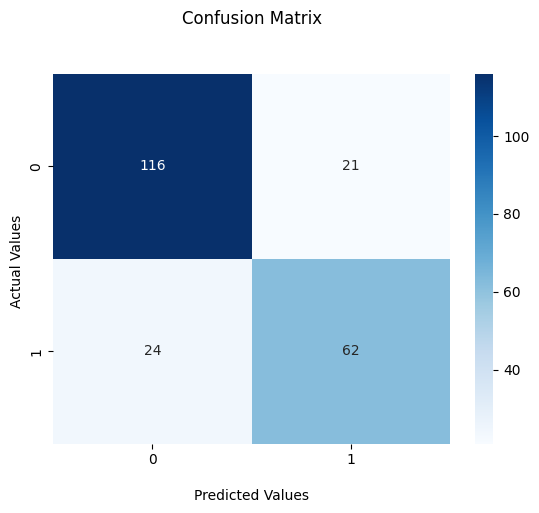

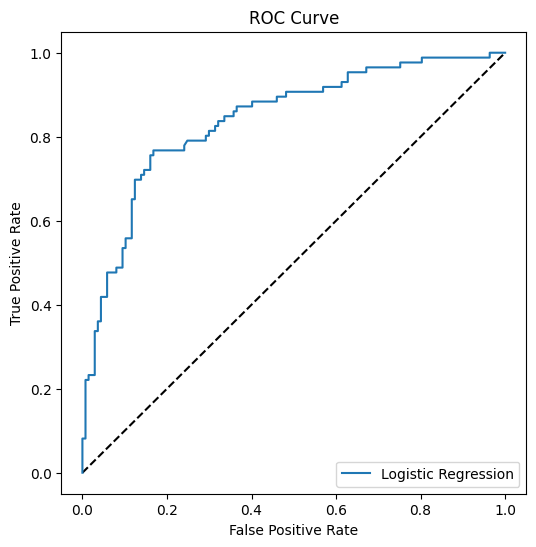

C:\Users\magda\AppData\Local\Temp\ipykernel_22624\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Logistic Regression,0.733728,0.840477


In [51]:
calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)

In [52]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())])

# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse=False ,handle_unknown='ignore'))])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)])

model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v2.fit(X_train, y_train)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('filter_name',
                                                                   Filter_Name(column='Name')),
                                                                  ('fill_missings',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Name', 'Sex',
                                                   'Embarked'])])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       137
           1       0.75      0.76      0.75        86

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



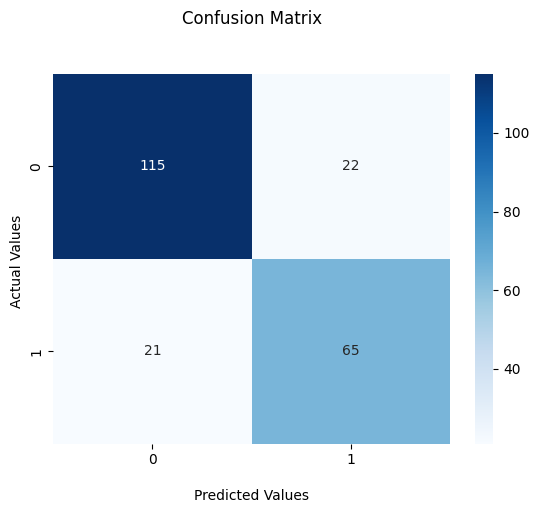

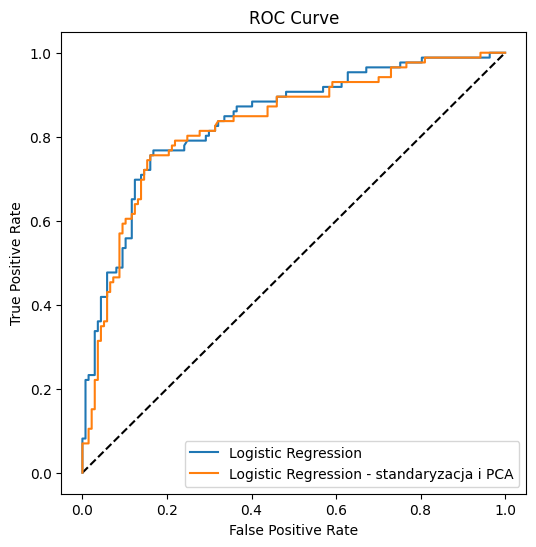

C:\Users\magda\AppData\Local\Temp\ipykernel_22624\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Logistic Regression,0.733728,0.840477
1,Logistic Regression - standaryzacja i PCA,0.751445,0.830122


In [53]:
calculate_metrics(model_pipeline_v2, 'Logistic Regression - standaryzacja i PCA', X_test, y_test)

In [54]:
model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [55]:
list(model_pipeline_v3.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__numeric_preprocessing',
 'preprocessor__categorical_preprocessing',
 'preprocessor__numeric_preprocessing__memory',
 'preprocessor__numeric_preprocessing__steps',
 'preprocessor__numeric_preprocessing__verbose',
 'preprocessor__numeric_preprocessing__fill_missings',
 'preprocessor__numeric_preprocessing__polynomial_features',
 'preprocessor__numeric_preprocessing__scaler_1',
 'preprocessor__numeric_preprocessing__pca',
 'preprocessor__numeric_preprocessing__scaler_2',
 'preprocessor__numeric_preprocessing__fill_missings__add_indicator',
 'preprocessor__numeric_preprocessing__fill_missings__copy',
 'preprocessor__numeric_preprocessing__fill_missings__fill_value',
 'preprocessor__numeric_pr

In [56]:
params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 
                                                                                0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(model_pipeline_v3, params, cv=10, n_jobs=-1, verbose=10, 
                            scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_v3 = grid_search.best_estimator_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Wybrane hiperparametry:  {'model__C': 0.12648552168552957, 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.99, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 3}


c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       137
           1       0.75      0.72      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



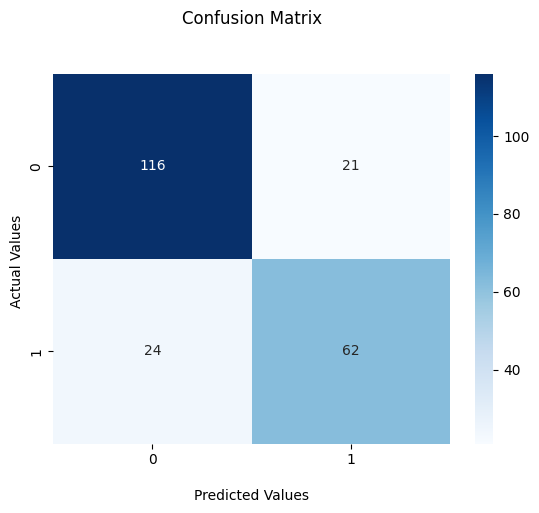

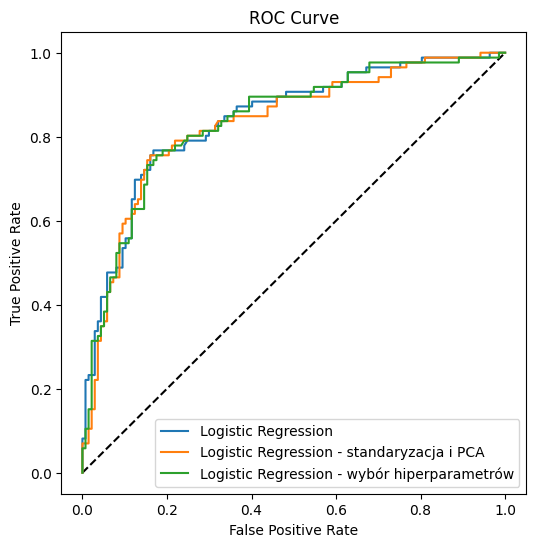

C:\Users\magda\AppData\Local\Temp\ipykernel_22624\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Logistic Regression,0.733728,0.840477
1,Logistic Regression - standaryzacja i PCA,0.751445,0.830122
2,Logistic Regression - wybór hiperparametrów,0.733728,0.836318


In [57]:
calculate_metrics(model_v3, 'Logistic Regression - wybór hiperparametrów', X_test, y_test)